# 4.7. Агломеративная кластеризация. Практика

Будем поочерёдно объединять близлежащие объекты (кластеры), пока весь датасет не войдёт в кластеры. Посмотрим, как реализуется агломеративная кластеризация в пакете Sklearn. При инициализации можно задать количество кластеров, функцию расстояния, способ определения ближайшего соседа:

In [1]:
from sklearn.cluster import AgglomerativeClustering

ac = AgglomerativeClustering(n_clusters=2,
                             affinity='euclidean', # “euclidean”, “l1”, “l2”, “manhattan”, 
                                                   # “cosine”, or “precomputed”
                             linkage='ward', # “ward”, “complete”, “average”, “single”
                            )

Посмотрим, как агломеративная кластеризация будет работать с нашими наборами данных. Мы будем варьировать только число кластеров. Будем также использовать матрицу смежности, для которой нужен параметр n_neighbors, то есть число ближайших соседей.

In [2]:
import numpy as np
from sklearn import datasets
from itertools import cycle, islice
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
np.random.seed(0)

# Количество объектов в каждом датасете
n_samples = 1500

# Вписанные круги
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
# Оставляем только признаки датасета, так как для кластеризации нам не нужны истинные классы объектов
X, y = noisy_circles
noisy_circles = X

# Полукруги
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
X, y = noisy_moons
noisy_moons = X

# Кластеры в форме круга
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
X, y = blobs
blobs = X

# Отсутствие кластерной структуры
no_structure = np.random.rand(n_samples, 2)

# Кластеры лентовидной формы
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = X_aniso

# Кластеры в форме кругов с различной дисперсией
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)
X, y = varied
varied = X

/var/folders/_q/03tkk3nx5xq63qd_bldrts5h0000gn/T/ipykernel_7764/2799895069.py:37: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(f'23{i}')
/var/folders/_q/03tkk3nx5xq63qd_bldrts5h0000gn/T/ipykernel_7764/2799895069.py:37: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(f'23{i}')
/var/folders/_q/03tkk3nx5xq63qd_bldrts5h0000gn/T/ipykernel_7764/2799895069.py:37: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(f'23{i}')
/var/folders/_q/03tkk3nx5xq63qd_bldrts5h0000gn/T/ipykernel_7764/2799895069.py:37: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 an

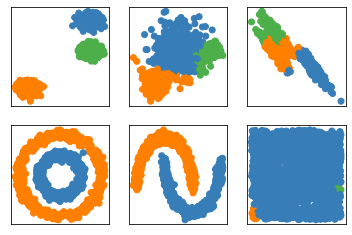

In [3]:
import warnings
import matplotlib.pyplot as plt
from sklearn.neighbors import kneighbors_graph

datasets_params_list = [
    (blobs, {'n_clusters': 3, 'n_neighbors': 10}),
    (varied, {'n_clusters': 3, 'n_neighbors': 2}),
    (aniso, {'n_clusters': 3, 'n_neighbors': 2}),
    (noisy_circles, {'n_clusters': 2, 'n_neighbors': 10}),
    (noisy_moons, {'n_clusters': 2, 'n_neighbors': 10}),
    (no_structure, {'n_clusters': 3, 'n_neighbors': 10})]

for i, (X, ac_params) in enumerate(datasets_params_list, start=1):
    X = StandardScaler().fit_transform(X)
    
    # строим матрицу смежности
    connectivity = kneighbors_graph(X, 
                                    n_neighbors=ac_params['n_neighbors'], 
                                    include_self=False)
    # делаем матрицу смежности симметричной
    connectivity = 0.5 * (connectivity + connectivity.T)
    
    ac = AgglomerativeClustering(n_clusters=ac_params['n_clusters'], 
                                 linkage='average',
                                 connectivity=connectivity)
    
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore",
            message="the number of connected components of the " +
            "connectivity matrix is [0-9]{1,2}" +
            " > 1. Completing it to avoid stopping the tree early.",
            category=UserWarning)
        ac.fit(X)
    y_pred = ac.labels_.astype(np.int)

    plt.subplot(f'23{i}')
    plt.xticks([]); plt.yticks([])
    colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                         '#f781bf', '#a65628', '#984ea3',
                                         '#999999', '#e41a1c', '#dede00']),
                                  int(max(y_pred) + 1))))
    plt.scatter(X[:, 0], X[:, 1], color=colors[y_pred])

In [4]:
def prepare_blobs():
    n_samples = 1500
    dataset = datasets.make_blobs(n_samples=n_samples, centers=2, center_box=(-7.0, 7.5), cluster_std=[1.4, 1.7], random_state=42)
    X_2, _ = datasets.make_blobs(n_samples=n_samples, random_state=170, centers=[[-4, -3]], cluster_std=[1.9])
    transformation = [[1.2, -0.8], [-0.4, 1.7]]
    X_2 = np.dot(X_2, transformation)
    X, y = np.concatenate((dataset[0], X_2)), np.concatenate((dataset[1], np.array([2] * len(X_2))))
    return X, y

X, y = prepare_blobs()

In [5]:
#Посмотрим распределение классов в датасете:
unique, counts = np.unique(y, return_counts=True)
dict(zip(unique, counts))

{0: 750, 1: 750, 2: 1500}

In [6]:
from sklearn.cluster import AgglomerativeClustering

ac = AgglomerativeClustering()
ac.fit(X)
ac.labels_

array([0, 0, 0, ..., 1, 1, 1])

## Задание 4.7.1

2.0/2.0 points (graded)
При каком значении параметра linkage при создании объекта AgglomerativeClustering критерием объединения кластеров будет среднее расстояние между объектами объединяемых кластеров?

linkage{‘ward’, ‘complete’, ‘average’, ‘single’}, default=’ward’
Which linkage criterion to use. The linkage criterion determines which distance to use between sets of observation. The algorithm will merge the pairs of cluster that minimize this criterion.

‘ward’ minimizes the variance of the clusters being merged.
‘average’ uses the average of the distances of each observation of the two sets.
‘complete’ or ‘maximum’ linkage uses the maximum distances between all observations of the two sets.
‘single’ uses the minimum of the distances between all observations of the two sets.

### ответ average

## Задание 4.7.2

2.0/2.0 points (graded)
Обучите модель AgglomerativeClustering с параметром n_clusters=3 на признаках исходного датасета. Напишите число листьев в иерархическом дереве, полученном при обучении:

In [7]:
ac = AgglomerativeClustering(n_clusters=3)
ac.fit(X)
len(ac.labels_)

3000

### ответ 3000

## Задание 4.7.3

2.0/2.0 points (graded)
Подсчитайте количество элементов в каждом из получившихся кластеров. Запишите в форму ниже три числа через пробел: количество элементов в кластере 0, в кластере 1 и в кластере 2.

Для подсчёта элементов в списке можно воспользоваться функцией numpy.unique с параметром return_counts=True:



In [8]:
import numpy as np
a = ac.labels_
counts = np.unique(a, return_counts=True)
for count in counts:
    print(count, end=' ')


[0 1 2] [1112 1142  746] 

### ответ 1112 1142  746

## Задание 4.7.4

2.0/2.0 points (graded)
При создании модели AgglomerativeClustering можно указать матрицу смежности, передав её в параметр connectivity. Построить матрицу смежности можно с помощью следующего кода:

In [9]:
from sklearn.neighbors import kneighbors_graph

connectivity = kneighbors_graph(X, n_neighbors=6, include_self=False)
connectivity = 0.5 * (connectivity + connectivity.T)

В переменной connectivity будет хранится матрица смежности для ненаправленного графа на основе датасета.

Обучите модель AgglomerativeClustering с параметром n_clusters=3 и составленной матрицей смежности на признаках исходного датасета. Подсчитайте количество элементов в каждом из получившихся кластеров. Выведите три числа через пробел: количество элементов в кластере 0, в кластере 1 и в кластере 2.

Подсказка: При решении данной задачи стандартизация должна быть выключена.

In [10]:
from sklearn import datasets
import numpy as np
def prepare_blobs():
    n_samples = 1500
    dataset = datasets.make_blobs(n_samples=n_samples, centers=2, center_box=(-7.0, 7.5), cluster_std=[1.4, 1.7], random_state=42)
    X_2, _ = datasets.make_blobs(n_samples=n_samples, random_state=170, centers=[[-4, -3]], cluster_std=[1.9])
    transformation = [[1.2, -0.8], [-0.4, 1.7]]
    X_2 = np.dot(X_2, transformation)
    X, y = np.concatenate((dataset[0], X_2)), np.concatenate((dataset[1], np.array([2] * len(X_2))))
    return X, y

X, y = prepare_blobs()

In [11]:
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import AgglomerativeClustering
import warnings
import matplotlib.pyplot as plt


# строим матрицу смежности
connectivity = kneighbors_graph(X, n_neighbors=6, include_self=False)
# делаем матрицу смежности симметричной
connectivity = 0.5 * (connectivity + connectivity.T)

ac = AgglomerativeClustering(n_clusters=3, linkage='average', connectivity=connectivity)
# with warnings.catch_warnings():
#     warnings.filterwarnings(
#         "ignore",
#         message="the number of connected components of the " +
#         "connectivity matrix is [0-9]{1,2}" +
#         " > 1. Completing it to avoid stopping the tree early.",
#         category=UserWarning)
#     ac.fit(X)
ac.fit(X)
y_pred = ac.labels_#.astype(np.int)



In [12]:
import numpy as np
a = ac.labels_
counts = np.unique(a, return_counts=True)
for count in counts:
    print(count, end=' ')


[0 1 2] [2998    1    1] 

### ответ 1486 746 768

## Задание 4.7.5

2.0/2.0 points (graded)
Постройте дендрограмму с помощью пакета scipy:

In [13]:
from sklearn import datasets
import numpy as np
def prepare_blobs():
    n_samples = 1500
    dataset = datasets.make_blobs(n_samples=n_samples, centers=2, center_box=(-7.0, 7.5), cluster_std=[1.4, 1.7], random_state=42)
    X_2, _ = datasets.make_blobs(n_samples=n_samples, random_state=170, centers=[[-4, -3]], cluster_std=[1.9])
    transformation = [[1.2, -0.8], [-0.4, 1.7]]
    X_2 = np.dot(X_2, transformation)
    X, y = np.concatenate((dataset[0], X_2)), np.concatenate((dataset[1], np.array([2] * len(X_2))))
    return X, y

X, y = prepare_blobs()

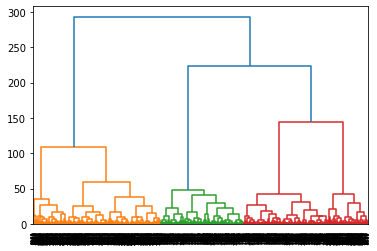

In [16]:
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt

Z = hierarchy.linkage(X, 'ward')
plt.figure()
dn = hierarchy.dendrogram(Z, leaf_rotation=90)
plt.show()

### ответ 3

## Задание 4.7.6

2.0/2.0 points (graded)
Сколько кластеров получится, если граничным расстоянием для разделения кластеров взять 100?

### ответ 5